In [1]:
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer

model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS") # 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-SBERT-V40K-klueNLI-augSTS") # 이 모델에서 사용한 Tokenizer. SentenceTransformer에선 필요 없음

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

c:\Users\jwj51720\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jwj51720\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

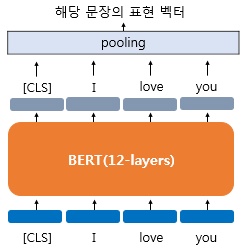

정리하면 사전 학습된 BERT로부터 문장 벡터를 얻는 방법은 다음과 같이 세 가지가 있습니다.

BERT의 [CLS] 토큰의 출력 벡터를 문장 벡터로 간주한다.
BERT의 모든 단어의 출력 벡터에 대해서 평균 풀링을 수행한 벡터를 문장 벡터로 간주한다.
BERT의 모든 단어의 출력 벡터에 대해서 맥스 풀링을 수행한 벡터를 문장 벡터로 간주한다.
이때 평균 풀링을 하느냐와 맥스 풀링을 하느냐에 따라서 해당 문장 벡터가 가지는 의미는 다소 다른데, 평균 풀링을 얻은 문장 벡터의 경우에는 모든 단어의 의미를 반영하는 쪽에 가깝다면, 맥스 풀링을 얻은 문장 벡터의 경우에는 중요한 단어의 의미를 반영하는 쪽에 가깝습니다.  
출처: https://wikidocs.net/156176

In [2]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

허깅페이스의 SentenceTransformer 모델은 여러 모듈(예: Transformer, Pooling)을 결합하여 문장 임베딩을 생성한다.  
출력에서 볼 수 있듯이 모듈 중 하나는 models.Transformer, 하나는 models.Pooling이다. 중괄호 안의 내용들을 내가 Custom하여 넣을 수 있다.  
여기서 Pooling은 데이터를 통합해 줄이는 역할을 한다. [1,2,3,4,5]라는 Tensor가 있다면, Max Pooling을 거쳤을 때 5, Mean Pooling을 거쳤을 때 3이 되겠다.  
Pooling 모듈의 기본 Pooling Setting에서 pooling_mode_mean_tokens: True인 것을 볼 수 있다.   
즉, 내가 입력으로 준 token들은 각각 768차원의 임베딩이 되는데, 이들의 평균을 취하여 output으로 내겠다는 의미이다.  

In [6]:
# 예시로 문장을 넣어보자.

tokenizer # 이 Tokenizer의 CLS 토큰은 2번이다.

BertTokenizerFast(name_or_path='snunlp/KR-SBERT-V40K-klueNLI-augSTS', vocab_size=40000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
example = "안녕하세요. 저는 진학사에 다니고 있습니다." 
SEQ_LEN = 128
token = tokenizer.encode(example, truncation=True, padding=False, add_special_tokens=True)
token # 실제로 CLS 토큰이 맨 앞에 붙어 있는 것을 볼 수 있다.

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[2, 19185, 18, 9770, 17353, 9651, 20797, 9023, 18, 3]

In [10]:
model.encode(example).shape

(768,)

내가 넣은 input의 token은 [2, 19185, 18, 9770, 17353, 9651, 20797, 9023, 18, 3]인데, 실제로 model의 output으로는 (768,)의 1차원 array가 나왔다.  
mean pooling이 되었기 때문이다.  
그럼 한번 커스텀해보자. 난 모든 token의 embedding을 얻고 싶다.

In [15]:
model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"

word_embedding_model = models.Transformer(model_name, max_seq_length=256)

model = SentenceTransformer(modules=[word_embedding_model])

In [18]:
model # pooling layer를 제거해버렸다.

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
)

In [19]:
result = model.encode(example, output_value='token_embeddings')
result.shape

torch.Size([10, 768])

확실히 [10, 768]인 걸 보니 [2, 19185, 18, 9770, 17353, 9651, 20797, 9023, 18, 3] 10개 토큰의 embedding이 모두 나왔다.  
저 중에서 가장 앞에 있는 것이 CLS 토큰의 임베딩일 것이다. 감성분석 Task는 CLS 토큰의 임베딩을 이진분류하는 것으로 유명하다.  
그럼 실제로 저 것의 첫 번째 임베딩이 CLS 토큰의 것이 맞는지 살펴보자.

In [32]:
is_cls = result[0] # 가장 첫 번째 것만 취함
print(is_cls[:10])
is_cls.shape

tensor([-2.0831,  1.5027,  0.3664, -0.9721, -0.5213, -0.7787, -0.1496, -0.0293,
         1.0156,  1.2694])


torch.Size([768])

In [23]:
# Transformer 모듈 로드
word_embedding_model = models.Transformer(model_name, max_seq_length=256)

# Pooling 모듈 설정
pooling_model = models.Pooling(
    word_embedding_dimension=word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=True, # 이번엔 Pooling Layer에서 CLS TOKEN만 True로 바꾸었다.
    pooling_mode_mean_tokens=False,
    pooling_mode_max_tokens=False,
    pooling_mode_mean_sqrt_len_tokens=False
)

# SentenceTransformer 모델 생성
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [33]:
result2 = model.encode(example)
result2[:10]

array([-2.0831187 ,  1.5026569 ,  0.36637175, -0.97212404, -0.52125424,
       -0.7786592 , -0.14956649, -0.0293241 ,  1.0156176 ,  1.2694006 ],
      dtype=float32)

In [36]:
print(is_cls[345: 355])
print(result2[345: 355]) # 똑같은 게 보인다. 반올림 차이 때문에 숫자는 약간 다르지만 동일한 값을 의미한다는 것은 알겠다.

tensor([ 0.2522,  0.4800,  0.5320,  0.4377,  0.3840, -0.4570,  0.4511, -1.4776,
         0.6831, -1.8406])
[ 0.2521757   0.48002505  0.53199536  0.4376778   0.38397276 -0.456951
  0.45110777 -1.4776334   0.68309206 -1.8406454 ]


만약 감성분석 Task를 수행할 것이라면 이 CLS 토큰의 임베딩 768차원 값을 가져다가 nn.linear로 2개 값으로 보내버리면 된다.   
그리고 softmax를 취해 합을 1로 만들어준다. loss는 이진 분류니까 cross entropy를 사용하면 될 것이다.  
그럼 우리의 경우는? nn.linear로 1개 값으로 보내버리면 되겠다. 그 값과 label(나이 점수)의 차이를 loss로 MSE, MAE, RMSE 등 loss function 설정하여 학습하면 끝이다.
근데 CLS만 가지고 하는 게 더 성능이 좋은지, MEAN POOLING이나 MAX POOLING이 더 성능이 좋을지는 해봐야 알 것 같다.  
마음대로 모델 구조를 바꾸면서 해보면 되겠다.

위에까지는 SentenceTransformer를 사용하는 방법이었다.  
SentenceTransformer는 내가 Input 문장을 tokenizing 할 필요가 없고, pooling도 알아서 붙어 있다.  
그래서 저건 문장을 임베딩하는 데에 많이 사용한다.  
일반적으로는 아래 AutoTokenizer, AutoModel을 사용한다.  

In [37]:
from transformers import AutoTokenizer, AutoModel
model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [54]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(40000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [40]:
model(example) # 이제는 이러면 오류가 난다. tokenizing이 되지 않았기 때문이다.

TypeError: string indices must be integers

In [47]:
example = "안녕하세요. 저는 진학사에 다니고 있습니다."
inputs = tokenizer(example, return_tensors='pt', max_length=256, padding='max_length', truncation=True) # 위에서 본 것처럼 tokenizer 사용
print(inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [51]:
(print(inputs['input_ids'][0][:15]))
(print(inputs['token_type_ids'][0][:15]))
(print(inputs['attention_mask'][0][:15]))

tensor([    2, 19185,    18,  9770, 17353,  9651, 20797,  9023,    18,     3,
            0,     0,     0,     0,     0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


input_ids는 tokenizing 된 token을 의미한다. [2, 19185, 18, 9770, 17353, 9651, 20797, 9023, 18, 3]가 되겠다.  
token_type_ids는 두 문장이 SEP TOKEN으로 연결되어 있을 때 사용하는 것이다. 보통 문장이 이어졌는지 아닌지 판단하는 TASK에서 사용한다.  
attention_mask는 어디까지가 진짜 input이고 어디부터 padding인지 알려준다. 앞에 10개만 1이고 나머지 max_length까지는 0이다.

In [52]:
outputs = model(**inputs)

In [60]:
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 256, 768])
torch.Size([1, 768])


In [73]:
print(outputs.last_hidden_state[0][0][345:355]) # CLS가 가장 앞에 있다. 아까 위에서 봤던 숫자와 동일하다.
print(outputs.last_hidden_state[0][1][345:355]) # 이제부터는 진짜 토큰들
print(outputs.last_hidden_state[0][-2][345:355]) # 패딩
print(outputs.last_hidden_state[0][-1][345:355]) # 패딩 -> position이 다르기 때문에 다른 embedding이 나온다. Transformer의 Positional Encoding 참조.

tensor([ 0.2522,  0.4800,  0.5320,  0.4377,  0.3840, -0.4570,  0.4511, -1.4776,
         0.6831, -1.8406], grad_fn=<SliceBackward0>)
tensor([-0.0315,  0.5800,  1.4216,  0.4184, -0.0334,  0.2474,  1.2193, -1.4339,
        -0.0507, -0.3206], grad_fn=<SliceBackward0>)
tensor([ 0.6642, -0.0170,  1.0080,  0.3886,  0.4695,  0.0686,  0.3521, -0.6086,
         0.0771, -1.0137], grad_fn=<SliceBackward0>)
tensor([ 0.8463, -0.3370,  1.2979,  0.2406,  0.0878,  0.1245,  0.4178, -0.7133,
         0.2221, -0.7483], grad_fn=<SliceBackward0>)


model의 output은 last_hidden_state과 pooler_output로 이루어진다.  
last_hidden_state은 Transformer 모델의 마지막 은닉층에서의 출력이다. 
우리가 위에서 얻었던 [10, 768]과 동일하다. 다만 여기서는 padding에 대한 embedding도 다 나오는 것이다.
결국 모든 token의 embedding을 가지고 싶다면? AutoModel로 모델을 불러오거나, SentenceTransformer에서 Pooling 제외하고 Transformer 모듈만 쓰면 된다.  
그리고 outputs.pooler_output은 CLS 토큰의 768 차원을 tanh 씌운 것이라고 한다. tanh 활성화 함수를 붙이는 게 감성분석 등의 task에서는 별로 좋지 않다고 한다.  
따라서 outputs.pooler_output는 무시하고 last_hidden_state의 CLS embedding을 가져다 쓰는 게 나을 수 있다.  
사실 classification 전용으로 AutoModelForSequenceClassification도 존재한다.   
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) 이러면 끝이라고 한다. 세상이 좋아졌다.

여기까지 SentenceTransformer와 AutoTokenizer, AutoModel의 사용법을 알아보았다. 이제 파인튜닝 하면 끝이다.